In [3]:
import pdal
pdal.__version__
import json
import pandas as pd
import numpy as np
import pdal
from pathlib import Path # KW_dense_cloud-22-58.las
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
from osgeo import gdal
import rasterio
import rioxarray as rxr
from rasterio.features import shapes

In [4]:
pdal.__version__

'3.4.5'

In [5]:
mesh_data = Path(r"P:\Korttid\pbm\Forcla Agnel sud\3Dmodel.obj")

In [6]:
def get_bin_statistics(array, length=1):
    df = pd.DataFrame(array)
    metadata = {
        "bin_x": np.floor(df.loc[:,"X"].min())+length/2,
        "bin_y": np.floor(df.loc[:,"Y"].min())+length/2,
        "bin_count": len(array),
        "bin_conf_sum": df.loc[:,"confidence"].sum()
    }
    
    return pd.DataFrame([metadata])

def get_bin_statistics_without_conf(array, length=1):
    df = pd.DataFrame(array)
    metadata = {
        "bin_x": np.floor(df.loc[:,"X"].min())+length/2,
        "bin_y": np.floor(df.loc[:,"Y"].min())+length/2,
        "bin_count": len(array)
        #"bin_conf_sum": df.loc[:,"Confidence"].sum()
    }
    
    return pd.DataFrame([metadata])

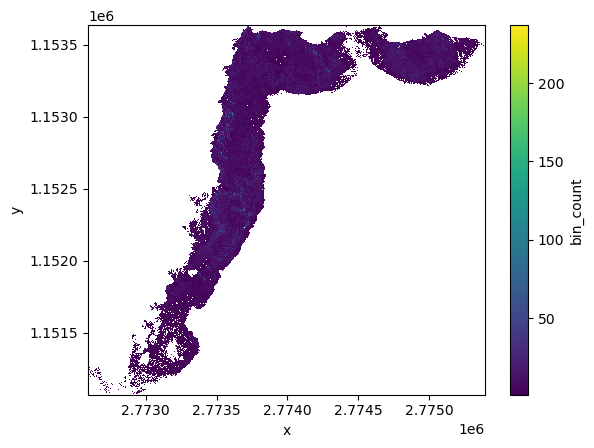

In [7]:
data = mesh_data

output = pd.DataFrame()

args = [
        {
            "type" : "readers.obj",
            "filename" : f"{str(Path(data))}",
        },
        {
            "type":"filters.splitter",
            "length":"1",
            "origin_x":"2600000.0",
            "origin_y":"1200000.0"
        }
    ]


pipeline = pdal.Pipeline(json.dumps(args))
count = pipeline.execute()
arrays = pipeline.arrays
metadata = pipeline.metadata
log = pipeline.log
for array in arrays:
    output = pd.concat([output, get_bin_statistics_without_conf(array)], ignore_index=True)
    
compiled_output = output.groupby(["bin_x","bin_y"]).sum().reset_index()

gdf = gpd.GeoDataFrame(compiled_output, geometry=gpd.points_from_xy(compiled_output.bin_x, compiled_output.bin_y))
# Set the CRS (assuming EPSG:32633 based on previous comments)
gdf.set_crs(epsg=2056, inplace=True)

gdf.rename(columns={'bin_x': 'x', 'bin_y': 'y'}, inplace=True)
# Convert GeoDataFrame to rioxarray object
rioxarray_obj = gdf.set_index(['y', 'x']).to_xarray()
rioxarray_obj = rioxarray_obj.drop_vars('geometry')
# Save the rioxarray object to a NetCDF file
rioxarray_obj.to_netcdf(mesh_data.parent / f"mesh_vertices_raster.nc")
rioxarray_obj["bin_count"].plot()

In [1]:

rioxarray_obj.to_netcdf(mesh_data.parent / f"mesh_vertices_raster.nc")
rioxarray_obj["bin_count"].plot()

NameError: name 'rioxarray_obj' is not defined